**********  CNN Pan-sharpening ***********

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
import pandas as pd
import tifffile as tiff
import cv2 as cv

In [ ]:
def upsample_bicubic(img,ratio):
  m,n,c=img.shape
  upsamp=cv.resize(img,(n*ratio,m*ratio),interpolation=cv.INTER_CUBIC)
  return upsamp

def downsample_bicubic(img,ratio):
  m,n,c=img.shape
  downsamp=cv.resize(img,(int(n/ratio),int(m/ratio)),interpolation=cv.INTER_CUBIC)
  return downsamp

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


(448, 448, 4)
(448, 448, 4)


(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f47b702dcd0>)

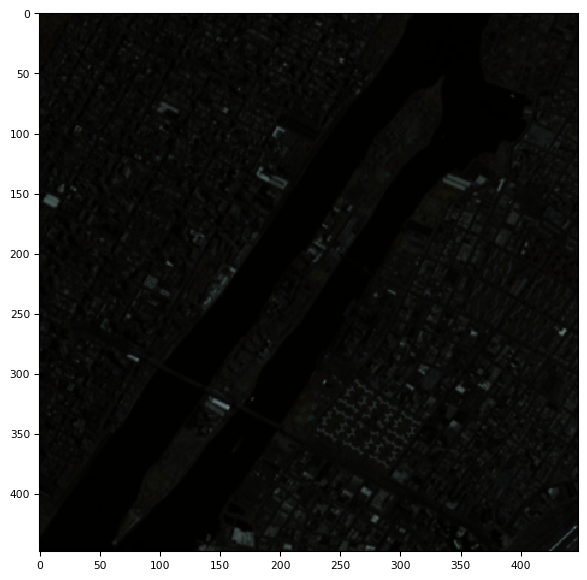

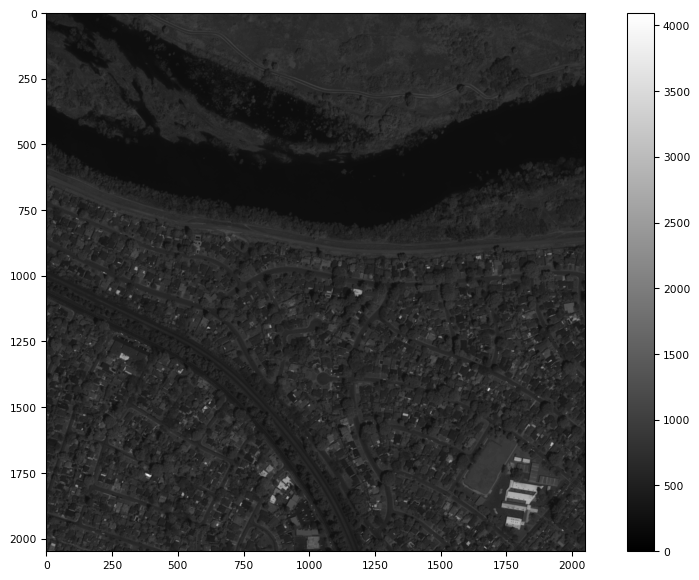

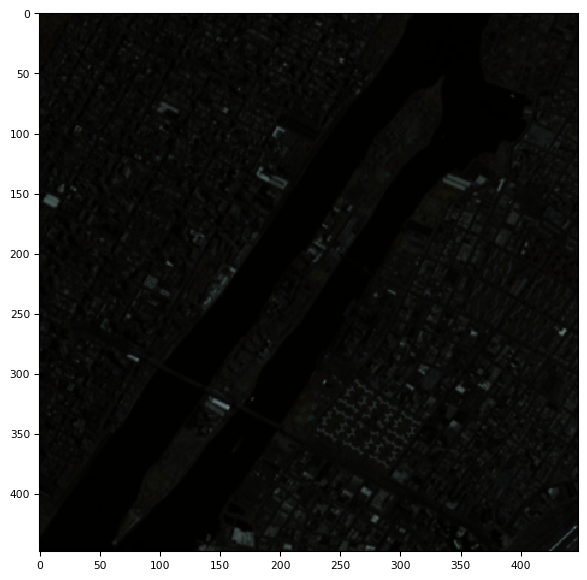

In [ ]:
ms=tiff.imread("/content/drive/MyDrive/dataset/PAirMax/PAirMax/FR/MS_LR/MS_LR5.tif")
print(ms.shape)
tiff.imshow(ms)
pan=tiff.imread("/content/drive/MyDrive/dataset/PAirMax/PAirMax/FR/PAN/PAN2.tif")
tiff.imshow(pan,cmap='gray')
orig=tiff.imread("/content/drive/MyDrive/dataset/PAirMax/PAirMax/GT/GT5.tif")
print(orig.shape)
tiff.imshow(orig)

In [ ]:
# print(pan.shape)

(1792, 1792, 1)


In [ ]:
# x_train=tf.image.extract_patches(images=up_ch,sizes=(1,64,64,1),strides=(1,32,32,1),rates=(1,1,1,1),padding='VALID')
# x_train=np.reshape(x_train,(-1,64,64,5))
# x_train=x_train.astype('float32')
# print(x_train.shape)

(225, 64, 64, 5)


In [ ]:
# print(orig.shape)

(448, 448, 4)


In [ ]:
import glob
import numpy as np
def get_dataset(X1_dir, X2_dir,Y_dir):
    ms_pan=[]
    gt=[]
    ms_pan_t = []
    gt_t = []
    for d in range(len(X1_dir)):
        ms1 = tiff.imread(X1_dir[d])
        pan= tiff.imread(X2_dir[d])
        gt1 = tiff.imread(Y_dir[d])
        # print(ms1.shape,pan.shape,gt1.shape)


        pan=np.expand_dims(pan,axis=-1)
        m,n,c=ms1.shape
        M,N,C=pan.shape

        pan_lr= downsample_bicubic(pan,4)
        ms_lr=downsample_bicubic(ms1,4)
        # print(ms_lr.shape)
        pan_lr=np.expand_dims(pan_lr,axis=-1)
        u_ms=upsample_bicubic(ms_lr,4)
        # print(pan_lr.shape)
        # print(u_ms.shape)
        up_ch= np.concatenate((pan_lr,u_ms),axis=-1)
        up_ch= np.expand_dims(up_ch,axis=0)


        patch_size=64; overlap=32
        x_train=tf.image.extract_patches(images=up_ch,sizes=(1,patch_size,patch_size,1),strides=(1,overlap,overlap,1),rates=(1,1,1,1),padding='VALID')
        x_train=np.reshape(x_train,(-1,patch_size,patch_size,5))
        x_train=x_train.astype('float32')
        # print(x_train.shape)

        y_train=np.expand_dims(gt1,axis=0)
        y_train=tf.image.extract_patches(images=y_train,sizes=(1,patch_size,patch_size,1),strides=(1,overlap,overlap,1),rates=(1,1,1,1),padding='VALID')
        y_train=np.reshape(y_train,(-1,patch_size,patch_size,4))
        y_train=y_train.astype('float32')
        # print(y_train.shape)
        if d==4:
          for i in range(y_train.shape[0]):
            gt_t.append(y_train[i])
            ms_pan_t.append(x_train[i])
        else:
          for i in range(y_train.shape[0]):
            gt.append(y_train[i])
            ms_pan.append(x_train[i])

    return ms_pan,gt,gt_t,ms_pan_t

X1_train = glob.glob("/content/drive/MyDrive/dataset/PAirMax/PAirMax/FR/MS_LR/*.tif")
X2_train = glob.glob("/content/drive/MyDrive/dataset/PAirMax/PAirMax/FR/PAN/*.tif")
y_train = glob.glob("/content/drive/MyDrive/dataset/PAirMax/PAirMax/GT/*.tif")

X1_train.sort()
X2_train.sort()
y_train.sort()

x_train, y_train, x_test, y_test = get_dataset(X1_train,X2_train, y_train)

x_train=np.array(x_train)
y_train=np.array(y_train)
print(x_train.shape)
print(y_train.shape)

x_test=np.array(x_test)
y_test=np.array(y_test)
print(x_test.shape)
print(y_test.shape)

(844, 64, 64, 5)
(844, 64, 64, 4)
(169, 64, 64, 4)
(169, 64, 64, 5)


In [ ]:
model=keras.Sequential([
                        keras.layers.Conv2D(filters=64,input_shape=(64, 64, 5),kernel_size=(9,9),activation='relu',strides=1,padding='same'),
                        keras.layers.Conv2D(filters=32,kernel_size=(5,5),activation='relu',strides=1,padding='same'),
                        keras.layers.Conv2D(filters=4,kernel_size=(5,5),activation='relu',strides=1,padding='same')
])

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.0001),loss=keras.losses.MeanSquaredError(),metrics=['mse','accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        25984     
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        51232     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 4)         3204      
                                                                 
Total params: 80,420
Trainable params: 80,420
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/dataset/cnn_4.h5', monitor='loss',verbose=1, save_best_only=True)

In [ ]:

model.fit(x_train,y_train,epochs=50,batch_size=32,callbacks=[model_checkpoint])

Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 344097.6562 - mse: 344097.6562 - accuracy: 0.7271
Epoch 1: loss improved from inf to 344097.65625, saving model to /content/drive/MyDrive/dataset/cnn_4.h5
10/10 [==============================] - 1s 117ms/step - loss: 344097.6562 - mse: 344097.6562 - accuracy: 0.7271
Epoch 2/50
 7/10 [====================>.........] - ETA: 0s - loss: 239047.8906 - mse: 239047.8906 - accuracy: 0.7301
Epoch 2: loss improved from 344097.65625 to 233459.25000, saving model to /content/drive/MyDrive/dataset/cnn_4.h5
10/10 [==============================] - 0s 23ms/step - loss: 233459.2500 - mse: 233459.2500 - accuracy: 0.7293
Epoch 3/50
 7/10 [====================>.........] - ETA: 0s - loss: 211951.3594 - mse: 211951.3594 - accuracy: 0.7700
Epoch 3: loss improved from 233459.25000 to 213858.89062, saving model to /content/drive/MyDrive/dataset/cnn_4.h5
10/10 [==============================] - 0s 24ms/step - loss: 213858.8906 - mse: 213858.

In [ ]:
model.load_weights('/content/drive/MyDrive/dataset/cnn_4.h5')

# For predicting the model take ms and pan images,upsample ms image to appropriate ratio,concatenate it with panchromatic and create patches to obtain x_test.
## For calculating metrics, we need to provide reference/ground truth(lower channel) as well as the upper_channel(up_ch) patches

(448, 448, 4)
(1792, 1792)
(448, 448, 4)
(1792, 1792, 4)


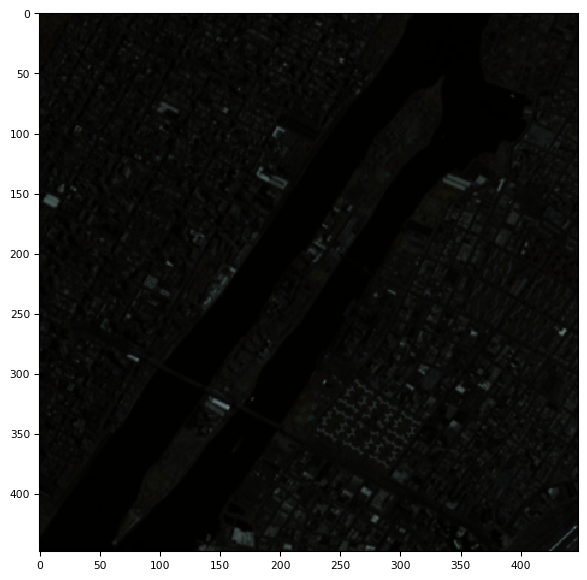

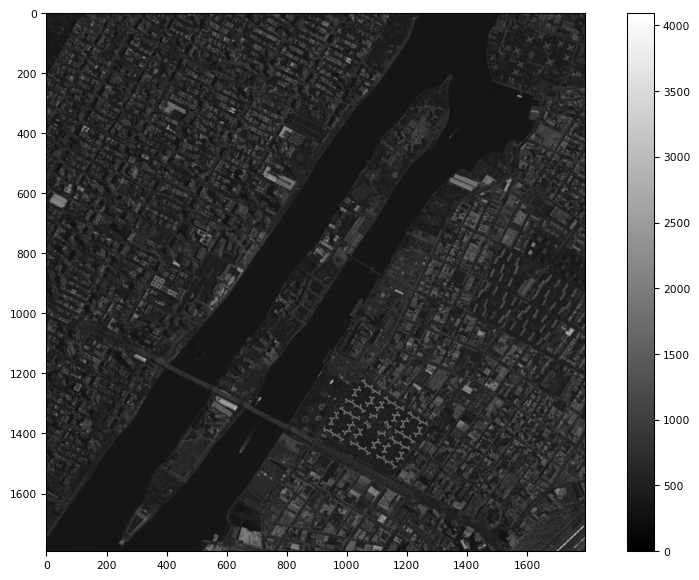

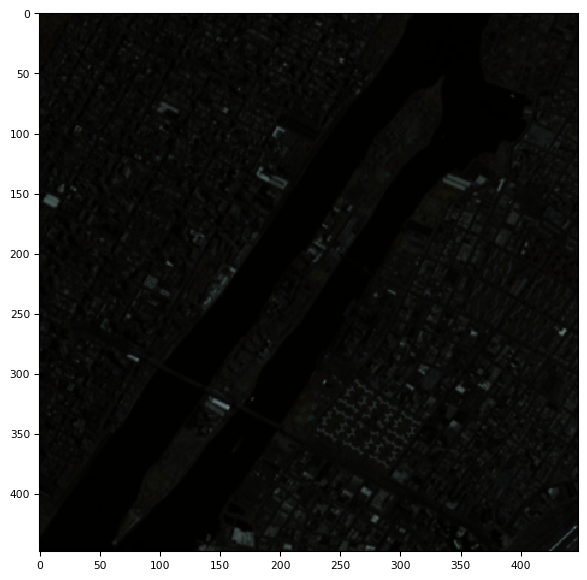

In [ ]:
ms=tiff.imread("/content/drive/MyDrive/dataset/PAirMax/PAirMax/FR/MS_LR/MS_LR5.tif")
tiff.imshow(ms)
print(ms.shape)
pan=tiff.imread("/content/drive/MyDrive/dataset/PAirMax/PAirMax/FR/PAN/PAN5.tif")
tiff.imshow(pan,cmap='gray')
print(pan.shape)
orig=tiff.imread("/content/drive/MyDrive/dataset/PAirMax/PAirMax/GT/GT5.tif")
tiff.imshow(orig)
print(orig.shape)
gt=tiff.imread("/content/drive/MyDrive/dataset/PAirMax/PAirMax/FR/MS/MS5.tif")
print(gt.shape)

In [ ]:
pann=np.expand_dims(pan,axis=-1)

In [ ]:

m,n,c=ms.shape
M,N,C=pann.shape

print(m,n,c)
print(M,N)
ratio=int(round(M/m))
assert int(round(M/m)) == int(round(N/n))

u_ms=upsample_bicubic(ms,ratio)
patch_size=64;overlap=64
inp=np.concatenate((pann,u_ms),axis=-1)
input=np.expand_dims(inp,axis=0)
inputs=tf.image.extract_patches(images=input,sizes=(1,patch_size,patch_size,1),strides=(1,overlap,overlap,1),rates=(1,1,1,1),padding='VALID')
x_test=np.reshape(inputs,(-1,patch_size,patch_size,5))
x_test=x_test.astype('float32')

448 448 4
1792 1792


In [ ]:
x_test.shape

(784, 64, 64, 5)

In [ ]:
pred = model.predict(x_test)
print(pred.shape)

(784, 64, 64, 4)


In [ ]:
y_train=np.expand_dims(gt1,axis=0)
        y_train=tf.image.extract_patches(images=y_train,sizes=(1,patch_size,patch_size,1),strides=(1,overlap,overlap,1),rates=(1,1,1,1),padding='VALID')
        y_train=np.reshape(y_train,(-1,patch_size,patch_size,4))
        y_train=y_train.astype('float32')

In [ ]:
def create_patches(img,patch_size,overlap):

    
    m,n,c=img.shape
    ilen=(m-patch_size)//overlap + 1
    jlen=(n-patch_size)//overlap + 1
    num=ilen*jlen
    patches=np.zeros((num,patch_size,patch_size,c))
    for i in range(ilen):
        for j in range(jlen):
            p=img[i*overlap:i*overlap + patch_size,j*overlap:j*overlap + patch_size,:]
            patches[i*jlen + j,:,:,:]=p
            
    patches=np.array(patches)
    return patches

In [ ]:
def merge_patch(patches,patch_size,overlap=1):
    num,m,n,c=patches.shape
    N= int(num**0.5)
    #img_rsize= ((num**0.5) -1)*overlap + patch_size 
    img_dim= N*m
    img=np.zeros((img_dim,img_dim,c))
    
    for i in range(N):
        i_st =i*overlap
        i_end= i_st +patch_size
        for j  in range(N):
            j_st =j*overlap
            j_end= j_st +patch_size
            img[i_st:i_end,j_st:j_end,:]=patches[i*N +j,:,:,:]
    print(img.shape)
    return img

(1792, 1792, 4)
(1792, 1792, 4)


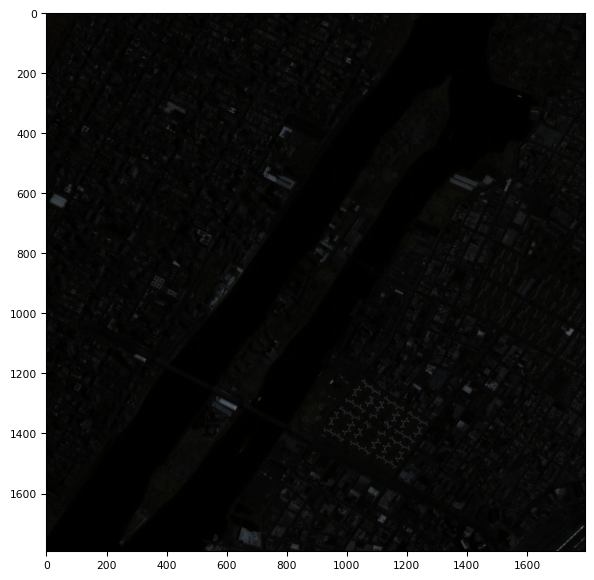

In [ ]:
final_img=merge_patch(pred,64,64)
tiff.imshow(final_img)
print(final_img.shape)

In [ ]:
import pickle
with open("/content/drive/MyDrive/dataset/CNN-4done.pkl",'wb') as f:
    pickle.dump(model,f)

INFO:tensorflow:Assets written to: ram://7d9d071a-41c6-49fa-8473-bd75592de224/assets


INFO:tensorflow:Assets written to: ram://7d9d071a-41c6-49fa-8473-bd75592de224/assets


In [ ]:
def predict_patch(x_test):
    num,m,n,c=x_test.shape
    pred=[]
    for i in range(num):
        patchi=np.expand_dims(x_test[i,:,:,:],axis=0)
        p= model.predict(patchi)
        pred.append(p)
    pred=np.array(pred)
    return pred

## **Calculating** **quantitative metrics**

In [ ]:
def rmse(out,inn):
    
    rmse= pow(np.mean((inn-out)**2),0.5)
    return rmse

def sam(out,inn):
    m,n,c=inn.shape
    inn=np.reshape(inn,(1,m*n*c))
    out=np.reshape(out,(1,m*n*c))
    mag_ms=np.linalg.norm(inn)
    mag_out=np.linalg.norm(out)
    prod = np.dot(inn,out.T)
    sam= np.arccos(prod/(mag_ms*mag_out))
    return sam

def uqi(out,inn):
    m,n,c=inn.shape
    inn=np.reshape(inn,(1,m*n*c))
    out=np.reshape(out,(1,m*n*c))
    l=m*n*c
    
    inn_m=np.mean(inn)  # x_bar
    out_m=np.mean(out)  # y_bar
    inn_s= np.sum((inn-inn_m)**2)/(l-1)             # sigma_x^2
    out_s= np.sum((out-out_m)**2)/(l-1)             # sigma_y^2
    com_s= np.sum((inn-inn_m)*(out-out_m))/(l-1)    # sigma_xy 
    
    uqi= (4*com_s*inn_m*out_m)/((inn_s + out_s)*(inn_m**2 + out_m**2))
    return uqi

def erga(out,inn,r):
    m,n,c =inn.shape
    s=0
    for i in range(c):
        s += (rmse(out[:,:,i],inn[:,:,i]))/(np.mean(inn[:,:,i])**2)    
    erga= 100*r*((s/c)**0.5)
    return erga

In [ ]:
u_ms=upsample_bicubic(ms,4)
print(u_ms.shape)

err1=rmse(final_img,u_ms)
print('rmse:',err1)

err2=sam(final_img,u_ms)
print("sam:",err2)

err3=uqi(final_img,u_ms)
print("uqi:",err3)

err4=erga(final_img,u_ms, r=1)
print("erga:",err4)

(1792, 1792, 4)
rmse: 102.55068075411059
sam: [[0.13627492]]
uqi: 0.9462146823125146
erga: 1.4948854483131757


In [ ]:
model_checkpoint = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/dataset/CNN-4new.h5', monitor='loss',verbose=1, save_best_only=True)
